In [77]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

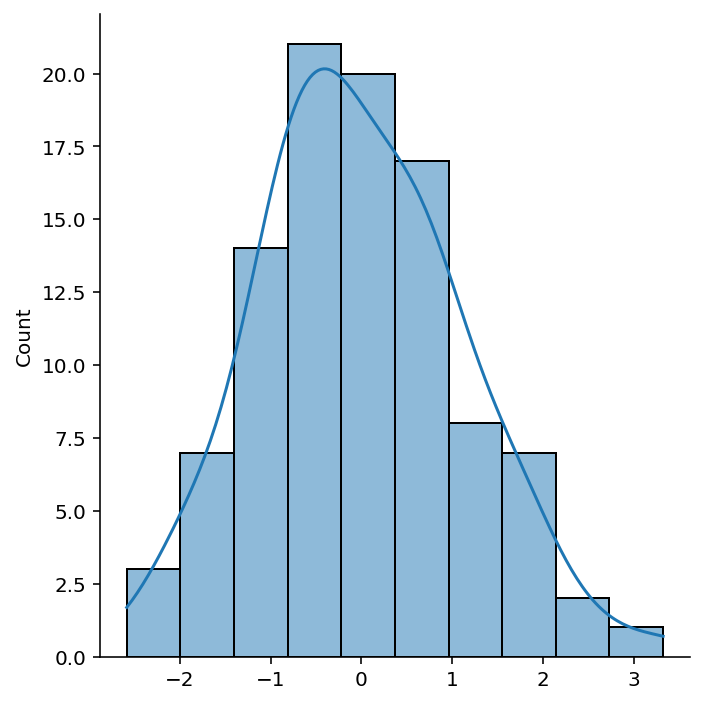

In [78]:
dist = torch.distributions.Normal(0, 1)

# Generate data
data = dist.sample((100,))

# Plot data
_ = sns.displot(data, kde=True)

In [79]:
# Let us pick up a set of K points and find the MLE for the mean and variance
def estimate_distribution_K_points(dataset, random_seed = 1, K = 5):
    assert K > 1
    assert K < len(dataset)

    # Set random seed
    torch.manual_seed(random_seed)

    # Sample K points
    sample = dataset[torch.randperm(len(dataset))[:K]]

    # Compute MLE for mean and variance
    mean = sample.mean()
    variance = sample.var()

    return mean, variance, sample




In [86]:
# Plot the MLE obtained distribution and sample points
def plot_distribution_and_sample_points(dataset, mean, variance, sample):
    dist = torch.distributions.Normal(mean, variance.sqrt())   
    x = torch.linspace(-3, 3, 1000)
    y = dist.log_prob(x).exp()
    plt.plot(x, y, label='MLE distribution')
    plt.scatter(sample, torch.zeros_like(sample) + 0.05, label='Sample points', s=100)
    # Plot true distribution
    true_dist = torch.distributions.Normal(0, 1)
    plt.plot(x, true_dist.log_prob(x).exp(), label='True distribution')
    
    plt.ylim(0, 2.0)

    # Mark mu and sigma on the plot
    plt.axvline(mean, color='r', linestyle='--', label='Estimated mean')
    plt.axvline(0, color='g', linestyle='--', label='True mean')
    plt.legend()

    

    


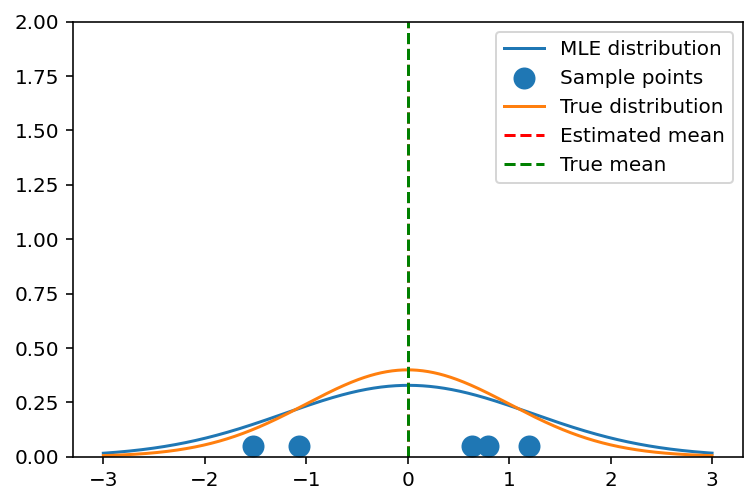

In [87]:
mean, variance, sample = estimate_distribution_K_points(data, K=5, random_seed=1)
plot_distribution_and_sample_points(data, mean, variance, sample)

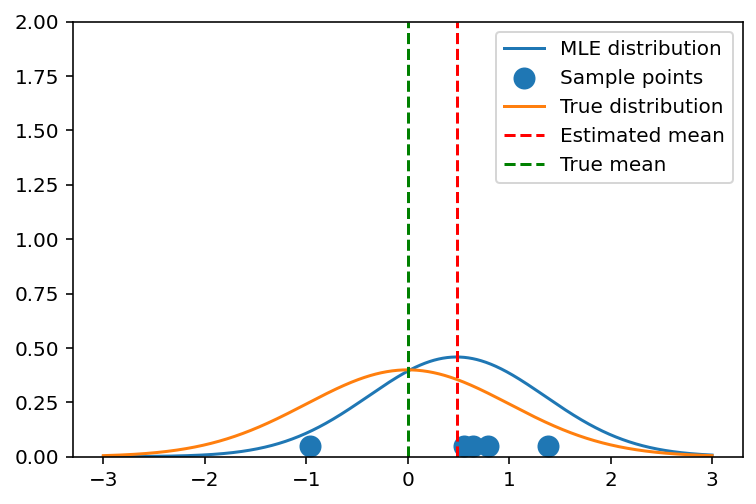

In [88]:
mean, variance, sample = estimate_distribution_K_points(data, K=5, random_seed=2)
plot_distribution_and_sample_points(data, mean, variance, sample)

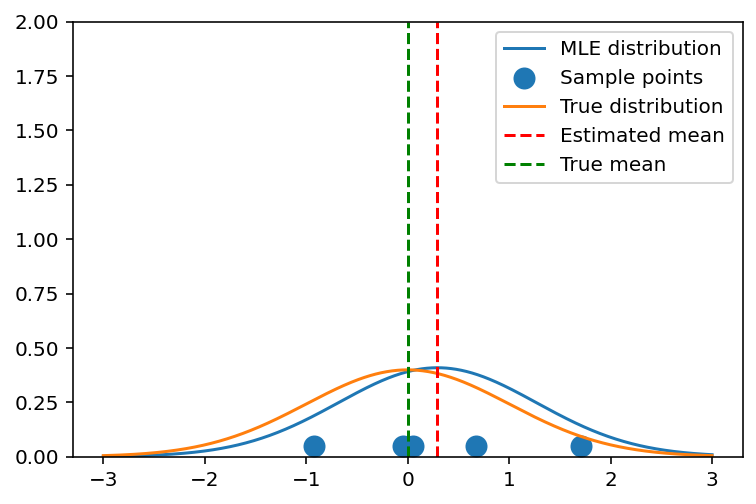

In [89]:
mean, variance, sample = estimate_distribution_K_points(data, K=5, random_seed=3)
plot_distribution_and_sample_points(data, mean, variance, sample)

In [101]:
# Let us now sample N such datasets of size K and compute the MLE for each of them for the mean and variance

def estimate_distribution_N_datasets(dataset, random_seed = 1, K = 5, N = 100):
    #assert K > 1
    #assert K < len(dataset)

    # Set random seed
    torch.manual_seed(random_seed)

    ds = torch.distributions.Normal(0, 1).sample((N, K))

    # Compute MLE for mean and variance
    means = ds.mean(dim=1)
    variances = ds.var(dim=1)

    return means, variances

In [102]:
means, variances = estimate_distribution_N_datasets(data, K=5, N=100, random_seed=1)



In [103]:
E_mu_mle = means.mean()
E_var_mle = variances.mean()

print(f'E[mu_mle] = {E_mu_mle}')
print(f'E[var_mle] = {E_var_mle}')

E[mu_mle] = 0.00591649767011404
E[var_mle] = 0.9792147278785706


In [104]:
# Calculate the bias in the MLE for the mean and variance

bias_mu_mle = E_mu_mle - 0
bias_var_mle = E_var_mle - 1

print(f'Bias[mu_mle] = {bias_mu_mle}')
print(f'Bias[var_mle] = {bias_var_mle}')

Bias[mu_mle] = 0.00591649767011404
Bias[var_mle] = -0.020785272121429443


In [105]:
# Function to estimate the mean, variance and bias in means and variance for a given K and N
def estimate_mean_variance_bias(dist, K = 5, N = 100):
    # Generate data
    data = dist.sample((N,))

    # Estimate mean and variance
    means, variances = estimate_distribution_N_datasets(data, K=K, N=N, random_seed=1)

    # Calculate the bias in the MLE for the mean and variance
    bias_mu_mle = means.mean() - dist.loc
    bias_var_mle = variances.mean() - dist.variance

    return bias_mu_mle, bias_var_mle


In [108]:
dist = torch.distributions.Normal(0, 1)
Ks = [2, 5, 10, 20, 50, 100]
Ns = [10, 100, 1000, 10000]

# Calculate the bias in the MLE for the mean and variance
biases = []
for K in Ks:
    for N in Ns:
        bias_mu_mle, bias_var_mle = estimate_mean_variance_bias(dist, K=K, N=N)
        biases.append([K, N, bias_mu_mle.item(), bias_var_mle.item()])

biases = pd.DataFrame(biases, columns=['K', 'N', 'bias_mu_mle', 'bias_var_mle'])


<AxesSubplot:xlabel='N'>

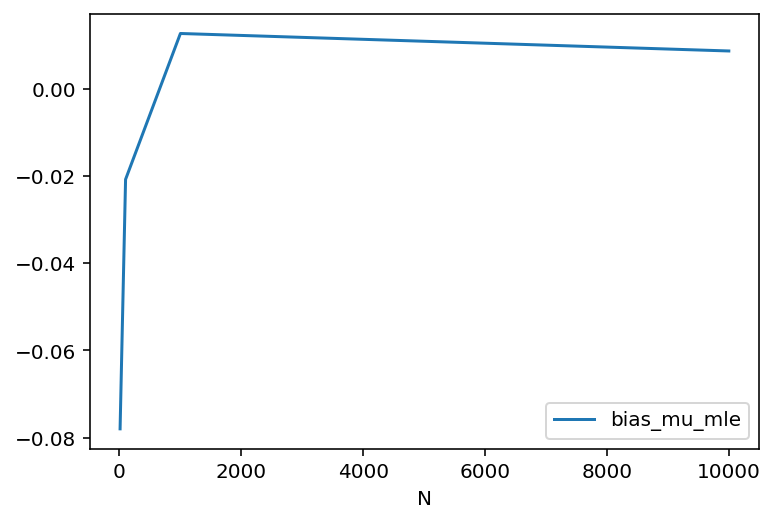

In [115]:
biases.query('K == 5').plot(x='N', y='bias_var_mle', label='bias_mu_mle')